# Sandbox

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import importlib

In [1]:
import qutip as qt

In [2]:
sys.path.append('..')

In [ ]:
import torch
import alpha_zero as az

In [3]:
import pulse_sequences as ps
import pulse_sequence_data as psd

In [4]:
# importlib.reload(az)
# importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

In [4]:
# default figure size is [6.0, 4.0]
plt.rcParams['figure.figsize'] = [4, 2.67]
# default dpi is 72
plt.rcParams['figure.dpi'] = 144

# Pulses and rotations

I can never keep it straight...

In [13]:
# thermal state
thermal = qt.thermal_dm(N=2, n=1)

In [12]:
X, Y, Z = qt.spin_J_set(.5)

In [17]:
# initial magnetization along Z
qt.expect(thermal, Z)

0.16666666666666666

In [30]:
rot = qt.propagator(Y, np.pi/2)

In [31]:
# apply a Y pulse
rot_state = rot * thermal * rot.dag()

In [32]:
# now magnetization is along X
qt.expect(rot_state, X)

0.16666666666666086

## F-matrix formalism

From [Choi et. al. 2020](https://arxiv.org/abs/1907.03771).

In [5]:
ps.pulse_names

['d', 'x', '-x', 'y', '-y']

In [4]:
psd.whh4

[0, 1, 4, 0, 3, 2]

In [17]:
for i, j in enumerate([5,4,3,2,1]):
    print(i,j)

0 5
1 4
2 3
3 2
4 1


In [5]:
def get_F_matrix(pulse_sequence):
    F = np.zeros((3, len(pulse_sequence)), int)
    taus = np.ones((len(pulse_sequence)), int)
    # taus vector ^ should be updated if pulse sequence
    # includes pi pulses
    frame = np.eye(3)
    for i, p in enumerate(pulse_sequence):
        frame = ps.rotations[p] @ frame
        axis = np.where(frame[-1, :])[0][0]
        F[axis, i] = frame[-1, axis]  # either ±1
    return F, taus

In [27]:
F, taus = get_F_matrix(psd.cory48)

In [34]:
# conditions 1 and 2
F.sum(axis=1), np.abs(F).sum(axis=1)

(array([0, 0, 0]), array([24, 24, 24]))

Two-body interaction cross-terms. To cancel them, the sequence matrix should contain an equal number of even and odd parities for every pair of neighboring frames between two axes; if the spin frame maintains (changes) its sign when switching to a different axis, the parity is defined as even (odd).

In [6]:
# parity condition, finite pulse width
def get_parity(F):
    parity = np.zeros((F.shape[0], F.shape[0], F.shape[1] - 1))
    for i in range(F.shape[1] - 1):
        axis_1 = np.where(F[:, i])[0][0]
        axis_2 = np.where(F[:, i + 1])[0][0]
        parity[axis_1, axis_2, i] = (F[axis_1, i] * F[axis_2, i + 1]
                                     + F[axis_2, i] * F[axis_1, i + 1])
    return parity

In [7]:
# chirality condition, rotation errors
def get_beta(F):
    beta = np.zeros((F.shape[0], F.shape[1] - 1))
    for i in range(F.shape[1] - 1):
        beta[:, i] = np.cross(F[:, i + 1], F[:, i])
    return beta

In [10]:
F, taus = get_F_matrix(psd.az48_3)
parity = get_parity(F)
beta = get_beta(F)

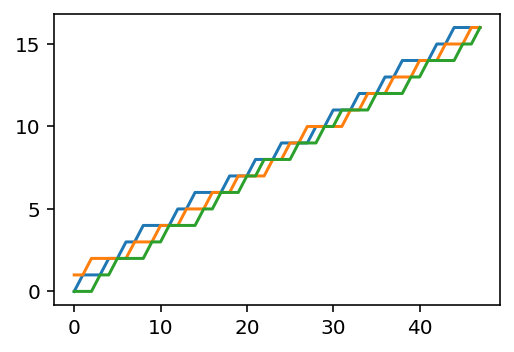

In [13]:
plt.plot(np.abs(F).cumsum(axis=1).T)

In [128]:
F.sum(axis=1), np.abs(F).sum(axis=1), parity.sum(axis=2), beta.sum(axis=1)

(array([0, 0, 0]),
 array([24, 24, 24]),
 array([[16.,  0.,  0.],
        [ 0., 16.,  0.],
        [ 0., -1., 16.]]),
 array([-1.,  0.,  0.]))

# Printing pulse sequences

In [6]:
print(psd.cory48)

[1, 3, 0, 2, 3, 0, 1, 3, 0, 1, 3, 0, 1, 4, 0, 1, 3, 0, 4, 2, 0, 3, 2, 0, 4, 2, 0, 4, 2, 0, 4, 1, 0, 4, 2, 0, 2, 3, 0, 2, 4, 0, 2, 3, 0, 1, 4, 0, 2, 4, 0, 1, 4, 0, 3, 2, 0, 3, 1, 0, 3, 2, 0, 4, 1, 0, 3, 1, 0, 4, 1, 0]


In [18]:
def print_pulse_sequence(ps):
    string = r''
    delay_count = 0
    for p in ps:
        if p == 0:
            delay_count += 1
            continue
        if delay_count == 1:
            string += r', \tau'
        elif delay_count > 1:
            string += f', {delay_count}\\tau'
        if p == 1:
            string += ', X'
        elif p == 2:
            string += r', \overline{X}'
        elif p == 3:
            string += ', Y'
        elif p == 4:
            string += r', \overline{Y}'
        delay_count = 1
    if delay_count == 1:
        string += r', \tau'
    elif delay_count > 1:
        string += f', {delay_count}\\tau'
    return string

In [61]:
a = print_pulse_sequence(psd.az_all_err_48)

In [63]:
print(' '.join(a.split(' ')[1:][:24]) + ' \\\\\n%')
print(' '.join(a.split(' ')[1:][24:48]) + '\\\\\n%')
print(' '.join(a.split(' ')[1:][48:72]) + '\\\\\n%')
print(' '.join(a.split(' ')[1:][72:96]) + '\\\\\n%')

X, \tau, X, \tau, \overline{Y}, \tau, X, \tau, X, \tau, \overline{Y}, \tau, \overline{X}, \tau, \overline{Y}, \tau, \overline{Y}, \tau, \overline{X}, \tau, \overline{Y}, \tau, \overline{Y}, \tau, \\
%
\overline{X}, \tau, \overline{Y}, \tau, \overline{Y}, \tau, \overline{X}, \tau, \overline{Y}, \tau, \overline{Y}, \tau, Y, \tau, Y, \tau, Y, \tau, \overline{X}, \tau, Y, \tau, Y, \tau,\\
%
\overline{X}, \tau, \overline{X}, \tau, Y, \tau, Y, \tau, \overline{X}, \tau, Y, \tau, Y, \tau, Y, \tau, \overline{X}, \tau, Y, \tau, Y, \tau, \overline{X}, \tau,\\
%
X, \tau, \overline{Y}, \tau, \overline{Y}, \tau, X, \tau, \overline{Y}, \tau, \overline{Y}, \tau, \overline{Y}, \tau, \overline{X}, \tau, \overline{X}, \tau, \overline{Y}, \tau, \overline{X}, \tau, \overline{X}, \tau\\
%


In [39]:
len(a.split(' ')[1:])

24

# Counting 6$\tau$ possibilities

In [6]:
allowed_transitions = {
    '+z': ['+x', '+y', '-x', '-y'],
    '-z': ['+x', '+y', '-x', '-y'],
    '+x': ['+z', '+y', '-z', '-y'],
    '-x': ['+z', '+y', '-z', '-y'],
    '+y': ['+x', '+z', '-x', '-z'],
    '-y': ['+x', '+z', '-x', '-z'],
}

In [8]:
initial_states = ['+z', '+x', '+y', '-x', '-y']

In [23]:
def count_paths(path):
    if len(path) == 0:
        count = 0
        for s in initial_states:
            count += count_paths([s])
        return count
    elif len(path) == 6:
        return 1
    else:
        count = 0
        for s in allowed_transitions[path[-1]]:
            if s not in path:
                count += count_paths(path + [s])
#         if len(path) == 3:
#             print(path, count)
        return count

In [24]:
count_paths([])

200

## Make decay plots

In [33]:
c48 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_1.csv', delimiter=',')
whh = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_2.csv', delimiter=',')
fid = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_3.csv', delimiter=',')
c48 = np.concatenate([[[0, 1]], c48])
whh = np.concatenate([[[0, 1]], whh])
fid = np.concatenate([[[0, 1]], fid])

In [34]:
cory48_1 = np.loadtxt('../../data/2021-03/Experimental/2021-03-13/c48_3_13.csv', delimiter=',')
yxx48 = np.loadtxt('../../data/2021-03/Experimental/2021-03-13/yxx48.csv', delimiter=',')
az48 = np.loadtxt('../../data/2021-03/Experimental/2021-03-13/az48.csv', delimiter=',')
cory48_1 = np.concatenate([[[0, 1]], cory48_1])
yxx48 = np.concatenate([[[0, 1]], yxx48])
az48 = np.concatenate([[[0, 1]], az48])

In [35]:
cory48_2 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_1.csv', delimiter=',')
yxx48_2 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/yxx48_6.csv', delimiter=',')
az48_2 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/az48_6.csv', delimiter=',')
cory48_2 = np.concatenate([[[0, 1]], cory48_2])
yxx48_2 = np.concatenate([[[0, 1]], yxx48_2])
az48_2 = np.concatenate([[[0, 1]], az48_2])

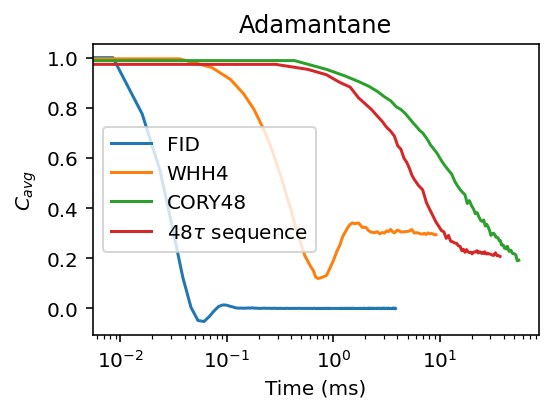

In [39]:
# plt.ylim(0, 1)
plt.plot(fid[:, 0], fid[:, 1], label='FID')
plt.plot(whh[:, 0], whh[:, 1], label='WHH4')
# plt.plot(c48[:, 0], c48[:, 1], label='cory48')

# from 3/13 experiments
plt.plot(cory48_1[:, 0], cory48_1[:, 1], label='CORY48')
# plt.plot(yxx48[:, 0], yxx48[:, 1], label='yxx48')
plt.plot(az48[:, 0], az48[:, 1], label=r'$48\tau$ sequence')

# from 3/18 experiments
# plt.plot(cory48_2[:, 0], cory48_2[:, 1], label='CORY48')
# plt.plot(yxx48_2[:, 0], yxx48_2[:, 1], label='yxx48 2')
# plt.plot(az48_2[:, 0], az48_2[:, 1], label=r'$48\tau$ sequence')

# plt.vlines(x=1e3, ymin=0, ymax=1, colors='k', label='T1')

plt.xscale('log')
plt.title('Adamantane')
plt.xlabel('Time (ms)')
plt.ylabel(r'$C_{avg}$')
plt.legend()
plt.savefig('decay_plot_3.pdf', bbox_inches='tight')

## Bloch sphere representations

In [156]:
from scipy.spatial.transform import Rotation

In [147]:
b = qt.Bloch()

In [151]:
z = qt.ket([0])
y = (qt.ket([0]) + 1j * qt.ket([1])).unit()

In [152]:
b.add_states([z, y])

In [162]:
# b.show()

In [154]:
x = np.array([0, 0, 1])

In [157]:
Rx = Rotation.from_euler('x', 5, degrees=True).as_matrix()
Ry = Rotation.from_euler('y', 5, degrees=True).as_matrix()

In [158]:
states = [np.linalg.matrix_power(Ry, i) @ x for i in range(10)]

In [159]:
xp, yp, zp = zip(*[(i[0], i[1], i[2]) for i in states])

In [160]:
# b.add_vectors(x)
# b.add_points(x)
b.add_points([xp, yp, zp])

In [25]:
b.save('test.png')

## Simulating decay plots

In [155]:
N = 3
dipolar_strength = 10
pulse_width = .002
delay = .008

In [6]:
Hsys = ps.get_Hsys(N=N, dipolar_strength=dipolar_strength)

In [58]:
X, Y, Z = ps.get_collective_spin(N=N)

In [9]:
Utarget = qt.identity([2]*N)

In [12]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=pulse_width, delay=delay)

In [16]:
U_cory48 = ps.get_propagator(ps.cory48, pulses)

In [17]:
U_yxx48 = ps.get_propagator(ps.yxx48, pulses)

In [19]:
U_az48 = ps.get_propagator(ps.az48_1, pulses)

In [151]:
# the first-order correction to the thermal density matrix is X
rho0 = X

In [154]:
# scale the signal amplitude by initial signal amplitude
S0 = qt.expect(X, rho0)
S0

6.0

In [156]:
T_cory48 = (pulse_width + delay) * len(ps.cory48)

In [158]:
T_yxx48 = (pulse_width + delay) * len(ps.yxx48)

In [189]:
T_az48 = (pulse_width + delay) * len(ps.az48_1)

In [180]:
S_cory48 = qt.expect(X, [U_cory48**i * rho0 * U_cory48.inv()**i for i in range(100)])

In [181]:
S_yxx48 = qt.expect(X, [U_yxx48**i * rho0 * U_yxx48.inv()**i for i in range(100)])

In [188]:
S_az48 = qt.expect(X, [U_az48**i * rho0 * U_az48.inv()**i for i in range(100)])

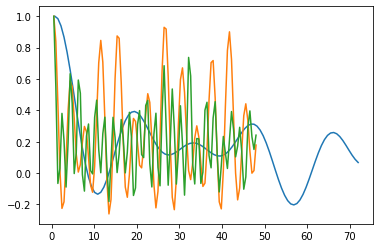

In [190]:
plt.plot(np.cumsum([T_cory48] * len(S_cory48)), np.real(S_cory48) / S0)
plt.plot(np.cumsum([T_yxx48] * len(S_yxx48)), np.real(S_yxx48) / S0)
plt.plot(np.cumsum([T_az48] * len(S_az48)), np.real(S_az48) / S0)

## Testing network

In [46]:
Utarget = qt.identity([2] * 3)

In [50]:
config = az.Config()

In [51]:
ps_config = ps.PulseSequenceConfig(Utarget=Utarget, max_sequence_length=48, ensemble_size=50)

In [52]:
net = az.Network()
net.load_state_dict(torch.load('../../data/2021-03/20210318-001837/network/0015500'))

<All keys matched successfully>

In [53]:
sequence = []
for _ in range(48):
    net_out = net(az.one_hot_encode(sequence).unsqueeze(0))
    sequence.append(np.argmax(net_out[0].detach().numpy()))

In [55]:
print(sequence[:48])

[1, 0, 3, 3, 3, 1, 0, 0, 2, 2, 1, 1, 4, 4, 4, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 0, 0, 4, 0, 0, 4, 0, 0]


In [57]:
net(az.one_hot_encode(sequence[:2]).unsqueeze(0))

(tensor([[0.2149, 0.2074, 0.0977, 0.4063, 0.0737]], grad_fn=<SoftmaxBackward>),
 tensor([[0.6596]], grad_fn=<AddmmBackward>),
 tensor([[[ 0.0184,  0.4001,  0.1349, -0.2431, -0.0820,  0.0110, -0.0622,
           -0.1905,  0.1547,  0.0031,  0.1600, -0.1841, -0.1064, -0.2506,
            0.0934,  0.0312,  0.0270, -0.2000, -0.0877,  0.0168, -0.0415,
           -0.0358, -0.1301, -0.0084, -0.0830, -0.1243, -0.2367, -0.0779,
            0.3372, -0.3977,  0.4100, -0.0324, -0.3736,  0.0365, -0.1006,
            0.0177, -0.0322,  0.0018,  0.2675, -0.0396,  0.0291, -0.0697,
           -0.1504, -0.1543,  0.0702,  0.4483, -0.2244,  0.1941,  0.0082,
           -0.0039,  0.0846, -0.2025,  0.2286, -0.2651, -0.2567, -0.1328,
            0.1296,  0.1194, -0.2189, -0.1830, -0.1389,  0.2297,  0.1967,
           -0.6680]]], grad_fn=<StackBackward>))

In [75]:
ps_config.reset()
output = az.make_sequence(config, ps_config, network=net, test=True,
                          rng=ps_config.rng, enforce_aht_0=True, max_difference=1)

In [76]:
print(output[-1])

([1, 4, 1, 4, 1, 4, 3, 3, 1, 1, 3, 1, 4, 1, 3, 3, 3, 1, 3, 4, 1, 1, 4, 1, 3, 1, 1, 3, 1, 1, 3, 4, 1, 1, 4, 1, 3, 2, 3, 3, 3, 2, 3, 1, 4, 4, 4], array([0., 1., 0., 0., 0.]), 1.6515496985335831)


In [74]:
ps.count_axes(output[-1][0])

[8, 8, 8, 7, 8, 8]

In [71]:
ps.count_axes([3, 3, 3, 1, 3, 3])

[1, 1, 1, 1, 1, 1]

## Testing ps_config parameter saving

In [216]:
output = np.load('../scripts/ps_config-0-no_net.npz')

In [222]:
np.std(output['rots'])

0.009820976650951307

In [202]:
cs = output['chemical_shifts']
dip_mat = output['dipolar_matrices']

In [203]:
N=3

In [204]:
Hsys_ensemble = []
offset = 0
for chemical_shifts, dipolar_matrix in zip(cs, dip_mat):
    Hcs = sum(
        [qt.tensor(
            [qt.identity(2)] * i
            + [(offset + chemical_shifts[i]) * qt.sigmaz()]
            + [qt.identity(2)] * (N - i - 1)
        ) for i in range(N)]
    )
    # dipolar interactions
    Hdip = sum([
        dipolar_matrix[i, j] * (
            2 * qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmaz()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmaz()]
                + [qt.identity(2)] * (N - j - 1)
            )
            - qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmax()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmax()]
                + [qt.identity(2)] * (N - j - 1)
            )
            - qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmay()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmay()]
                + [qt.identity(2)] * (N - j - 1)
            )
        )
        for i in range(N) for j in range(i + 1, N)
    ])
    
    Hsys_ensemble.append(Hcs + Hdip)

In [213]:
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=0.01)
    pulses_ensemble.append(
        ps.get_pulses(H, X, Y, Z, pulse_width=1e-5, delay=1e-4, rot_error=rot)
    )

In [214]:
f = ps.get_mean_fidelity([3, 4, 4, 2, 4, 4, 2, 2, 3, 3, 2, 3], Utarget, pulses_ensemble)
-np.log10(1 - f)

2.5015571286258496

## Simulation

In [83]:
Hsys, params = ps.get_Hsys(N=3, offset=1e0, dipolar_strength=1e2, return_all=True)

In [84]:
X, Y, Z = ps.get_collective_spin(N=3)

In [88]:
output = qt.mesolve(Hsys, X, tlist=np.linspace(0, 15e-2, 500), e_ops=[X, Y, Z])

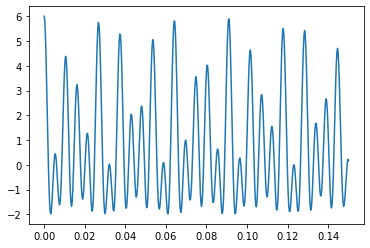

In [89]:
plt.plot(output.times, output.expect[0])

In [90]:
params

(array([0.56365476, 0.13010873, 0.8971216 ]),
 0.20856764728178212,
 array([[-127.71305054, -145.45596682,   84.50100052],
        [ -17.43951414,  101.06205672,   26.8447102 ],
        [-181.97074045,  -41.18745734,  -14.02630326]]))

In [123]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=1e-5, delay=1e-4, phase_transient=0)

In [122]:
(pulses[1] * pulses[1] * pulses[1] * pulses[1]).tr()/8

(-0.9957933313517151+3.114655634936449e-05j)

In [91]:
ps.get_pulses

<function pulse_sequences.get_pulses(Hsys, X, Y, Z, pulse_width=0.0001, delay=0.001, rot_error=0, phase_transient=0, rng=None)>

## ML

In [131]:
import torch
import numpy as np
import torch.multiprocessing as mp
from time import sleep
from torch.utils.tensorboard import SummaryWriter

In [129]:
import alpha_zero as az

In [132]:
writer = SummaryWriter('runs/sandbox')

In [133]:
net = az.Network()

In [145]:
net

Network(
  (gru): GRU(6, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (policy): Linear(in_features=32, out_features=5, bias=True)
  (value): Linear(in_features=32, out_features=1, bias=True)
)

In [143]:
input = torch.zeros((1, 10, 6))

In [144]:
writer.add_graph(net, input)

In [45]:
def worker(proc_num, queue):
    for _ in range(6000):
        if _ % 500 == 0:
            print(f'in {proc_num} on iteration {_}')
        rng = np.random.default_rng()
        length = rng.integers(48)
        state = rng.random(size=(length, 6))
        probs = rng.random(size=(5,))
        value = rng.random(size=(1,))
        datum = (state, probs, value)
        queue.put(datum)
#         with lock:
#             if len(buffer) < buffer_size:
#                 buffer.append(datum)
#                 index.value += 1
#             else:
#                 buffer[index.value] = datum
#                 index.value += 1
#             if index.value >= buffer_size:
#                 index.value = 0
    return


def checker(queue, output, buffer_size=24000):
    buffer = []
    index = 0
    while len(buffer) < buffer_size:
        if queue.empty():
            sleep(1)
            continue
        buffer.append(queue.get())
        index += 1
    output.put(buffer)

In [2]:
if __name__ == '__main__':
    # TODO start processes, try adding 450 * 48 * (tensor, tensor, tensor) to shared list
    # and see if I run into similar issues...
    with mp.Manager() as manager:
        queue = manager.Queue()
        output = manager.Queue()
#         length = manager.Value('i', 0)
#         index = manager.Value('i', 0)
#         lock = manager.Lock()
        workers = []
        for i in range(4):
            w = mp.Process(target=worker, args=(i, queue))
            w.start()
            workers.append(w)
        w = mp.Process(target=checker, args=(queue, output))
        w.start()
        workers.append(w)
        for w in workers:
            w.join()
        print('all processes joined')
#         buffer = list(buffer)
#         index = index.value
        buffer = output.get()

In [41]:
buffer[2][2]

array([0.54937819])

In [47]:
[a[2] for a in buffer[:10]]

[array([0.76290919]),
 array([0.15618292]),
 array([0.79988231]),
 array([0.24052051]),
 array([0.95798373]),
 array([0.92766788]),
 array([0.49542138]),
 array([0.11634498]),
 array([0.28900658]),
 array([0.93548941])]

In [48]:
len(buffer)

24000

In [3]:
np.random.gamma(.3, 1, 5)

array([4.51142846e-05, 1.63684981e-06, 1.90767475e-01, 1.66719882e-01,
       1.15576553e-09])

In [4]:
rng = np.random.default_rng()

In [25]:
rng.gamma(.3, 1, 5)

array([0.04235174, 0.17385871, 0.00208078, 0.00103263, 0.00506793])

In [26]:
rng.dirichlet([1e-1] * 5)

array([2.93925569e-03, 9.96016686e-01, 1.04404191e-03, 5.75735218e-20,
       1.66749759e-08])

## Comparing refocusing times for different sequences

In [67]:
def make_plot(pulse_sequence, name='ps'):
    counts = [ps.count_axes(pulse_sequence[:i]) for i in range(len(pulse_sequence))]
    counts = np.array(counts)
    plt.plot(counts[:, 0] + counts[:, 3], label='±x')
    plt.plot(counts[:, 1] + counts[:, 4], label='±y')
    plt.plot(counts[:, 2] + counts[:, 5], label='±z')
    plt.title(name)
    plt.xlabel(r'$\tau$ period')
    plt.ylabel(r'$\tau$ periods spent on axis')
    plt.legend()
    plt.show()
    plt.plot(counts[:, 0], label='+x')
    plt.plot(counts[:, 1], label='+y')
    plt.plot(counts[:, 2], label='+z')
    plt.plot(counts[:, 3], label='-x')
    plt.plot(counts[:, 4], label='-y')
    plt.plot(counts[:, 5], label='-z')
    plt.title(name)
    plt.xlabel(r'$\tau$ period')
    plt.ylabel(r'$\tau$ periods spent on axis')
    plt.legend()
    plt.show()
    return counts

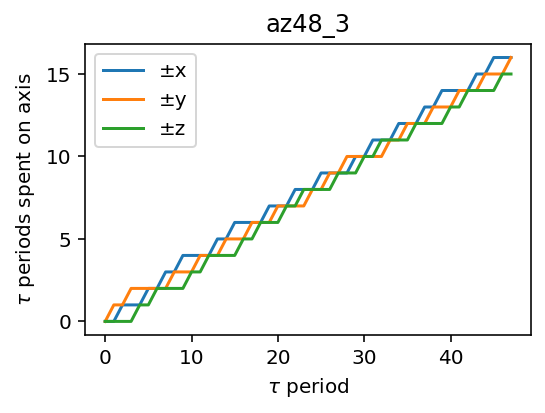

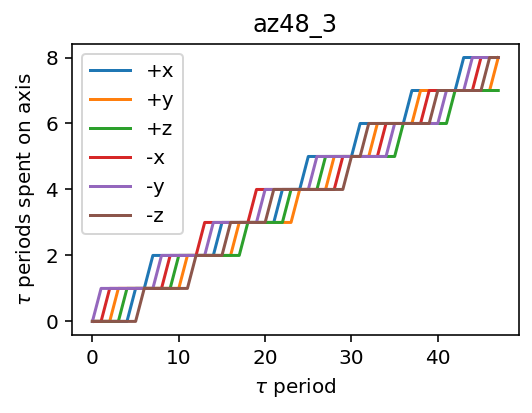

In [68]:
az48_counts = make_plot(psd.az48_3, name='az48_3')

In [87]:
((np.array(psd.cory48) == 0).sum(),
 (np.array(psd.cory48) == 1).sum(),
 (np.array(psd.cory48) == 2).sum(),
 (np.array(psd.cory48) == 3).sum(),
 (np.array(psd.cory48) == 4).sum())

(24, 12, 12, 12, 12)

In [85]:
((np.array(psd.yxx48) == 1).sum(),
 (np.array(psd.yxx48) == 2).sum(),
 (np.array(psd.yxx48) == 3).sum(),
 (np.array(psd.yxx48) == 4).sum())

(16, 16, 8, 8)

In [86]:
((np.array(psd.az48_3) == 1).sum(),
 (np.array(psd.az48_3) == 2).sum(),
 (np.array(psd.az48_3) == 3).sum(),
 (np.array(psd.az48_3) == 4).sum())

(18, 8, 9, 13)

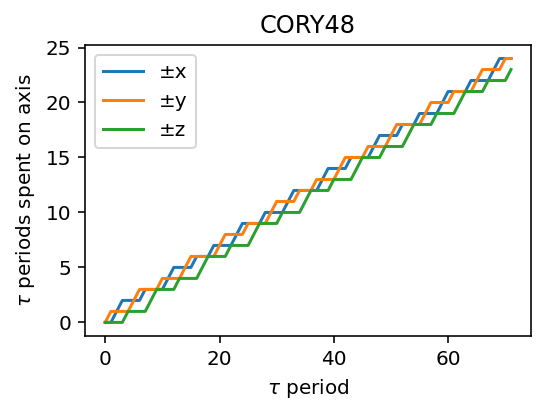

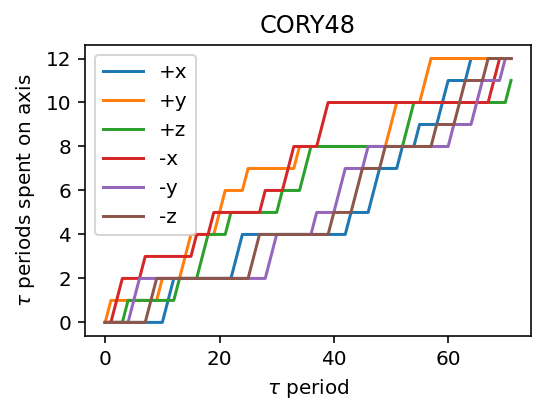

In [72]:
cory48_counts = make_plot(psd.cory48, 'CORY48')

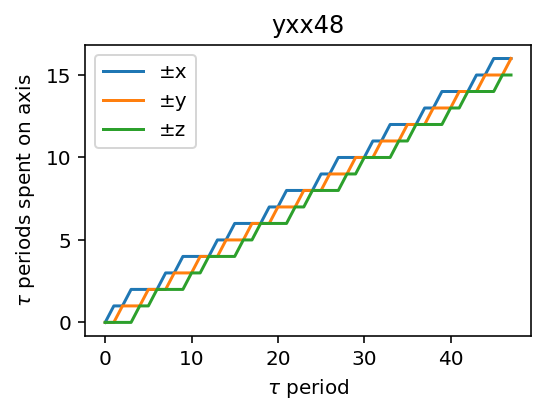

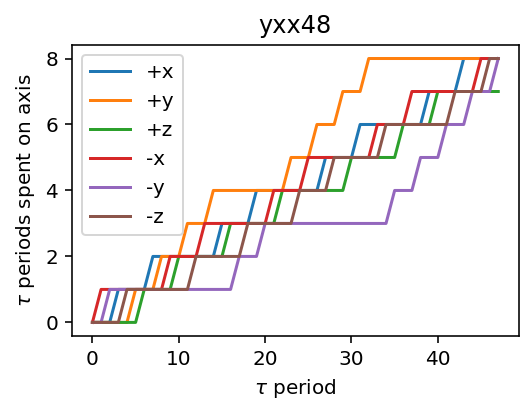

In [71]:
yxx48_counts = make_plot(psd.yxx48, 'yxx48')

Looks like cory48 doesn't refocus interactions all that frequently... But it keeps it relatively close, so you don't spend a lot of time on one particular axis. 